In [148]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from tensorflow.keras.layers import Dropout, MaxPooling2D, AveragePooling2D, Dense, Flatten, Input, Conv2D, add, Activation
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, Reshape, Layer,
                          BatchNormalization, LocallyConnected2D,
                          ZeroPadding2D, Conv2D, MaxPooling2D, Conv2DTranspose,
                          GaussianNoise, UpSampling2D, Input)

from tensorflow.keras import applications
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential , Model , load_model
from tensorflow.keras.preprocessing.image import load_img , img_to_array , ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from PIL import Image
import matplotlib.pyplot as plt

import cv2
from imutils import paths
import numpy as np
import os
import math
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
import time


In [149]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [150]:
train_data_dir = 'C:\\Users\\Pandiepie\\soil\\train'  
test_data_dir = 'C:\\Users\Pandiepie\soil\\test' 

In [151]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 10

In [152]:
scale_image = ImageDataGenerator(rescale=1. / 255)  

train_dataset = scale_image.flow_from_directory(  
         train_data_dir,  
         target_size=(IMG_SIZE),  
         batch_size=batch_size,   
         shuffle=True) 

validation_dataset = scale_image.flow_from_directory(  
         test_data_dir,  
         target_size=(IMG_SIZE),  
         batch_size=batch_size,  
         shuffle=True) 

Found 482 images belonging to 8 classes.
Found 326 images belonging to 8 classes.


In [153]:
num_examples= len(train_dataset.filenames)
num_classes= len(train_dataset.class_indices)
BATCH_SIZE = 32

In [154]:
do_fine_tuning = False 

In [155]:
feature_extractor = hub.KerasLayer(
    MODULE_HANDLE,
    input_shape=IMAGE_SIZE + (3,),
    output_shape=[FV_SIZE],
    trainable=do_fine_tuning,
)

In [156]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential(
    [feature_extractor, tf.keras.layers.Dense(num_classes, activation="softmax")]
)

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_10 (KerasLayer)  (None, 1280)              2257984   
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 10248     
Total params: 2,268,232
Trainable params: 10,248
Non-trainable params: 2,257,984
_________________________________________________________________


In [157]:
# @title (Optional) Unfreeze some layers
NUM_LAYERS = 17  # @param {type:"slider", min:1, max:50, step:1}

if do_fine_tuning:
    feature_extractor.trainable = True

    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable = True

else:
    feature_extractor.trainable = False

In [158]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [159]:
EPOCHS = 10

hist = model.fit(train_dataset,
                 epochs=EPOCHS,
                 validation_data=validation_dataset)

Epoch 1/10
16/16 [==============================] - 19s 1s/step - loss: 1.8733 - accuracy: 0.3465 - val_loss: 1.3397 - val_accuracy: 0.5675
Epoch 2/10
16/16 [==============================] - 15s 923ms/step - loss: 1.0929 - accuracy: 0.6598 - val_loss: 0.9073 - val_accuracy: 0.6902
Epoch 3/10
16/16 [==============================] - 18s 1s/step - loss: 0.7852 - accuracy: 0.7365 - val_loss: 0.7056 - val_accuracy: 0.7914
Epoch 4/10
16/16 [==============================] - 16s 1s/step - loss: 0.5943 - accuracy: 0.8257 - val_loss: 0.5674 - val_accuracy: 0.8436
Epoch 5/10
16/16 [==============================] - 16s 1s/step - loss: 0.4934 - accuracy: 0.8714 - val_loss: 0.4729 - val_accuracy: 0.8773
Epoch 6/10
16/16 [==============================] - 16s 987ms/step - loss: 0.4230 - accuracy: 0.8900 - val_loss: 0.4094 - val_accuracy: 0.9018
Epoch 7/10
16/16 [==============================] - 15s 910ms/step - loss: 0.3601 - accuracy: 0.9170 - val_loss: 0.3522 - val_accuracy: 0.9325
Epoch 8/10


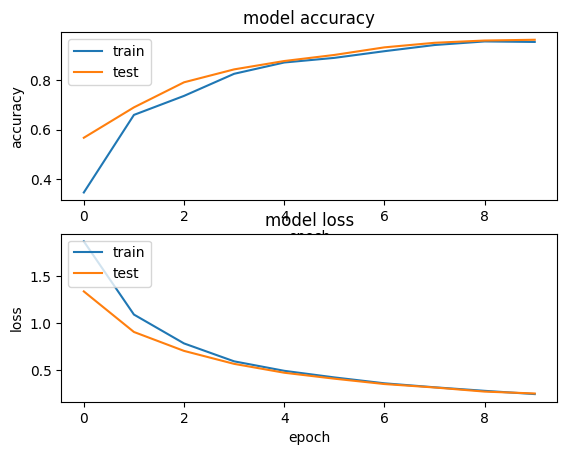

In [160]:
plt.figure(1)  
   
plt.subplot(211)  
plt.plot(hist.history['accuracy'])  
plt.plot(hist.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
plt.subplot(212)  
plt.plot(hist.history['loss'])  
plt.plot(hist.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

In [123]:
# preds= np.round(model.predict(validation_dataset))
# soil_type = ['Aluvial', 'Andosol', 'Grumusol', 'Laterit', 'Mediteran', 'Organosol', 'Podsolit', 'Regosol']
# classificiation_metrics = metrics.classification_report(validation_dataset,preds,target_names=soil_type)
# print(classificiation_metrics)

In [134]:
# image_path = '1d447b4cfd644b33a1615ec7c2035a7a-5a9b4ad6f1334464e9492725.jpg'  
   
# orig = cv2.imread(image_path)  
   
# print("[INFO] loading and preprocessing image...")  
# image = load_img(image_path, target_size=(224, 224))  
# image = img_to_array(image)  
   
# image = image / 255  
   
# image = np.expand_dims(image, axis=0)

In [132]:
# # build the VGG16 network  
# module_selection = ("mobilenet_v2", 224, 1280)
   
# # get the bottleneck prediction from the pre-trained VGG16 model  
# pred = module_selection.predict(image)  
   
# # # build top model  
# # model = Sequential()  
# # model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))  
# # model.add(Dense(64, activation='relu'))  
# # model.add(Dropout(0.5))  
# # model.add(Dense(num_classes, activation='softmax'))  
   
# # model.load_weights(top_model_weights_path)  
# class_predicted = model.predict_classes(pred)  

In [133]:
# inID = class_predicted[0]  
   
# class_dictionary = generator_top.class_indices  
   
# inv_map = {v: k for k, v in class_dictionary.items()}  
   
# label = inv_map[inID]  
   
#  # get the prediction label  
# print("Image ID: {}, Label: {}".format(inID, label))  
   
#  # display the predictions with the image  
# cv2.putText(orig, "Predicted: {}".format(label), (10, 30), cv2.FONT_HERSHEY_PLAIN, 1.5, (43, 99, 255), 2)  
   
# cv2.imshow("Classification", orig)  
# cv2.waitKey(0)  
# cv2.destroyAllWindows() 

In [165]:
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [166]:
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

In [168]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [169]:
from tensorflow import lite
saved_model_dir = 'Model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
with open('soil_classification_model.tflite', 'wb') as f:
 f.write(tflite_model)

INFO:tensorflow:Assets written to: Model\assets


INFO:tensorflow:Assets written to: Model\assets
